In [1]:
%pip install tensorflow keras-tuner pandas scikit-learn openimages tqdm


In [2]:
import os
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
import numpy as np

from openimages.download import download_images, download_dataset


In [3]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


In [4]:
# Define constants
CATEGORIES = ['Bird', 'Cat', 'Dog']  # Selected categories
IMAGES_PER_CATEGORY = 400  # Number of images to download per category
TRAIN_SIZE = 200  # Number of training images per category
VALID_SIZE = 100  # Number of validation images per category
TEST_SIZE = 100  # Number of testing images per category
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
DATA_DIR = 'data'  # Base directory for data
ANNOTATIONS_DIR = 'annotations'  # Directory for annotations
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'validation')
TEST_DIR = os.path.join(DATA_DIR, 'test')
LOG_DIR = 'logs'
HYPERPARAMETER_RESULTS_FILE = os.path.join(LOG_DIR, 'hyperparameter_results.csv')
TRAINING_LOG_FILE = os.path.join(LOG_DIR, 'training_log.csv')


In [5]:
def create_directories():
    """
    Creates the necessary directory structure for data storage.
    """
    directories = [
        DATA_DIR,
        ANNOTATIONS_DIR,
        TRAIN_DIR,
        VALID_DIR,
        TEST_DIR,
        LOG_DIR
    ]
    for directory in directories:
        if not os.path.exists(directory):
            os.makedirs(directory)
            print(f"Created directory: {directory}")
        else:
            print(f"Directory already exists: {directory}")
    
    # Create subdirectories for each category in train, validation, and test
    for subset_dir in [TRAIN_DIR, VALID_DIR, TEST_DIR]:
        for category in CATEGORIES:
            category_path = os.path.join(subset_dir, category)
            if not os.path.exists(category_path):
                os.makedirs(category_path)
                print(f"Created directory: {category_path}")
            else:
                print(f"Directory already exists: {category_path}")

create_directories()


Directory already exists: data
Directory already exists: annotations
Directory already exists: data\train
Directory already exists: data\validation
Directory already exists: data\test
Directory already exists: logs
Directory already exists: data\train\Bird
Directory already exists: data\train\Cat
Directory already exists: data\train\Dog
Directory already exists: data\validation\Bird
Directory already exists: data\validation\Cat
Directory already exists: data\validation\Dog
Directory already exists: data\test\Bird
Directory already exists: data\test\Cat
Directory already exists: data\test\Dog


In [6]:
def is_data_downloaded(category, data_dir, images_per_category=IMAGES_PER_CATEGORY):
    """
    Checks if the required number of images for a category have already been downloaded.
    
    Args:
        category (str): The category name.
        data_dir (str): The base data directory.
        images_per_category (int): The minimum number of images required.
        
    Returns:
        bool: True if data is downloaded, False otherwise.
    """
    images_path = os.path.join(data_dir, category, 'images')
    if not os.path.exists(images_path):
        return False
    num_images = len([name for name in os.listdir(images_path) 
                      if os.path.isfile(os.path.join(images_path, name))])
    return num_images >= images_per_category

def is_annotations_downloaded(category, data_dir):
    """
    Checks if annotations for a category have already been downloaded.
    
    Args:
        category (str): The category name.
        data_dir (str): The base data directory.
        
    Returns:
        bool: True if annotations are downloaded, False otherwise.
    """
    pascal_path = os.path.join(data_dir, category, 'pascal')
    if not os.path.exists(pascal_path):
        return False
    num_annotations = len([name for name in os.listdir(pascal_path) 
                           if os.path.isfile(os.path.join(pascal_path, name))])
    return num_annotations > 0


In [7]:
def download_images_only():
    """
    Downloads images for the specified categories using the download_images function.
    Skips downloading if images already exist.
    Images are saved in 'data/<Category>/images/' directories.
    """
    print("\nStarting download of images only...")
    for category in CATEGORIES:
        if is_data_downloaded(category, DATA_DIR):
            print(f"Images for category '{category}' already downloaded. Skipping download.")
        else:
            print(f"Downloading images for category '{category}'...")
            try:
                download_images(DATA_DIR, [category])
                print(f"Downloaded images for category '{category}' successfully.")
            except Exception as e:
                print(f"An error occurred while downloading images for '{category}': {e}")

download_images_only()



Starting download of images only...
Images for category 'Bird' already downloaded. Skipping download.
Images for category 'Cat' already downloaded. Skipping download.
Images for category 'Dog' already downloaded. Skipping download.


In [8]:
def download_images_with_annotations():
    """
    Downloads images and their corresponding annotations in PASCAL VOC format
    for the specified categories using the download_dataset function.
    Skips downloading if annotations already exist.
    Annotations are saved in 'data/<Category>/pascal/' directories.
    """
    print("\nStarting download of images with annotations...")
    for category in CATEGORIES:
        if is_annotations_downloaded(category, DATA_DIR):
            print(f"Annotations for category '{category}' already downloaded. Skipping download.")
        else:
            print(f"Downloading images and annotations for category '{category}'...")
            try:
                download_dataset(DATA_DIR, [category], annotation_format="pascal")
                print(f"Downloaded images and annotations for category '{category}' successfully.")
            except Exception as e:
                print(f"An error occurred while downloading dataset for '{category}': {e}")

download_images_with_annotations()



Starting download of images with annotations...
Annotations for category 'Bird' already downloaded. Skipping download.
Annotations for category 'Cat' already downloaded. Skipping download.
Annotations for category 'Dog' already downloaded. Skipping download.


In [9]:
def verify_downloads():
    """
    Verifies that the required number of images and annotations have been downloaded for each category.
    """
    print("\nVerifying downloaded images and annotations...")
    for category in CATEGORIES:
        # Verify images
        images_path = os.path.join(DATA_DIR, category, 'images')
        if os.path.exists(images_path):
            num_images = len([name for name in os.listdir(images_path) 
                              if os.path.isfile(os.path.join(images_path, name))])
            print(f"Category '{category}' has {num_images} images.")
        else:
            print(f"Images directory not found for category '{category}'.")
        
        # Verify annotations
        pascal_path = os.path.join(DATA_DIR, category, 'pascal')
        if os.path.exists(pascal_path):
            num_annotations = len([name for name in os.listdir(pascal_path) 
                                   if os.path.isfile(os.path.join(pascal_path, name))])
            print(f"Category '{category}' has {num_annotations} annotation files.")
        else:
            print(f"Annotations directory not found for category '{category}'.")

verify_downloads()



Verifying downloaded images and annotations...
Category 'Bird' has 9545 images.
Category 'Bird' has 9545 annotation files.
Category 'Cat' has 4085 images.
Category 'Cat' has 4085 annotation files.
Category 'Dog' has 6088 images.
Category 'Dog' has 6088 annotation files.


In [10]:
def split_data():
    """
    Splits the downloaded images into training, validation, and test sets.
    Copies images into 'train', 'validation', and 'test' directories accordingly.
    """
    print("\nSplitting data into training, validation, and test sets...")
    for category in CATEGORIES:
        # Source images path
        source_dir = os.path.join(DATA_DIR, category, 'images')
        images = [img for img in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, img))]
        if len(images) < (TRAIN_SIZE + VALID_SIZE + TEST_SIZE):
            print(f"Warning: Not enough images in category '{category}'. "
                  f"Expected at least {TRAIN_SIZE + VALID_SIZE + TEST_SIZE}, found {len(images)}.")
        
        random.shuffle(images)
        
        train_images = images[:TRAIN_SIZE]
        valid_images = images[TRAIN_SIZE:TRAIN_SIZE + VALID_SIZE]
        test_images = images[TRAIN_SIZE + VALID_SIZE:TRAIN_SIZE + VALID_SIZE + TEST_SIZE]
        
        # Define destination directories
        train_dest = os.path.join(TRAIN_DIR, category)
        valid_dest = os.path.join(VALID_DIR, category)
        test_dest = os.path.join(TEST_DIR, category)
        
        # Function to copy images
        def copy_images(image_list, src, dst):
            for img in image_list:
                src_path = os.path.join(src, img)
                dst_path = os.path.join(dst, img)
                shutil.copy(src_path, dst_path)
        
        copy_images(train_images, source_dir, train_dest)
        copy_images(valid_images, source_dir, valid_dest)
        copy_images(test_images, source_dir, test_dest)
        
        print(f"Category '{category}': {len(train_images)} train, {len(valid_images)} validation, {len(test_images)} test images.")

split_data()



Splitting data into training, validation, and test sets...
Category 'Bird': 200 train, 100 validation, 100 test images.
Category 'Cat': 200 train, 100 validation, 100 test images.
Category 'Dog': 200 train, 100 validation, 100 test images.


In [11]:
def setup_generators():
    """
    Sets up ImageDataGenerators for training, validation, and testing datasets.
    Applies data augmentation to the training data.
    """
    print("\nSetting up ImageDataGenerators...")
    
    # Data augmentation for training data
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest'
    )
    
    # Only rescaling for validation and test data
    valid_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Flow from directory for training data
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    
    # Flow from directory for validation data
    valid_generator = valid_test_datagen.flow_from_directory(
        VALID_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    
    # Flow from directory for test data
    test_generator = valid_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False  # Important for evaluation
    )
    
    return train_generator, valid_generator, test_generator

train_generator, valid_generator, test_generator = setup_generators()



Setting up ImageDataGenerators...
Found 600 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [12]:
def build_model(hp):
    """
    Builds and compiles the CNN model with hyperparameters.
    Utilizes ResNet50 as the base model.
    
    Args:
        hp (kt.HyperParameters): Hyperparameter tuning object.
        
    Returns:
        tensorflow.keras.Model: Compiled model.
    """
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
    
    # Hyperparameter for number of layers to freeze
    freeze_layers = hp.Int('freeze_layers', min_value=0, max_value=len(base_model.layers), step=10)
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Hyperparameters for Dense layers
    num_dense_layers = hp.Int('num_dense_layers', 1, 3)
    for i in range(num_dense_layers):
        units = hp.Int(f'units_{i}', min_value=64, max_value=512, step=64)
        x = Dense(units=units, activation='relu')(x)
        dropout_rate = hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)
        x = Dropout(rate=dropout_rate)(x)
    
    predictions = Dense(len(CATEGORIES), activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Hyperparameters for optimizer
    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd'])
    if optimizer_choice == 'adam':
        learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
        optimizer = Adam(learning_rate=learning_rate)
    else:
        learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
        momentum = hp.Float('momentum', 0.0, 0.9, step=0.1)
        optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [13]:
def initialize_tuner():
    """
    Initializes the Keras Tuner with a Random Search strategy.
    
    Returns:
        keras_tuner.tuners.RandomSearch: Initialized tuner.
    """
    print("\nInitializing Keras Tuner...")
    tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=50,  # Adjust based on computational resources
        executions_per_trial=1,
        directory='kt_dir',
        project_name='image_classification',
        overwrite=True
    )
    return tuner

tuner = initialize_tuner()



Initializing Keras Tuner...


In [14]:
def define_callbacks():
    """
    Defines callbacks for early stopping and model checkpointing.
    """
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_path = os.path.join(LOG_DIR, 'best_model.keras')  # Changed to .keras
    model_checkpoint = ModelCheckpoint(
        checkpoint_path, 
        monitor='val_accuracy', 
        save_best_only=True,
        save_weights_only=False  # Save the entire model
        # Removed save_format to avoid compatibility issues
    )
    return early_stop, model_checkpoint

early_stop, model_checkpoint = define_callbacks()


In [ ]:
def perform_hyperparameter_search(tuner, train_gen, valid_gen):
    """
    Performs hyperparameter search using the provided tuner.
    
    Args:
        tuner (kt.tuners.RandomSearch): Hyperparameter tuner.
        train_gen (DirectoryIterator): Training data generator.
        valid_gen (DirectoryIterator): Validation data generator.
    """
    print("\nStarting hyperparameter search...")
    tuner.search(
        train_gen,
        epochs=20,
        validation_data=valid_gen,
        callbacks=[early_stop, model_checkpoint]
    )

perform_hyperparameter_search(tuner, train_generator, valid_generator)


Trial 20 Complete [00h 11m 17s]
val_accuracy: 0.5099999904632568

Best val_accuracy So Far: 0.5799999833106995
Total elapsed time: 05h 17m 57s

Search: Running Trial #21

Value             |Best Value So Far |Hyperparameter
60                |150               |freeze_layers
1                 |3                 |num_dense_layers
384               |192               |units_0
0.4               |0.3               |dropout_0
adam              |sgd               |optimizer
0.0063946         |0.0030784         |learning_rate
448               |256               |units_1
0.4               |0.3               |dropout_1
128               |448               |units_2
0.3               |0.1               |dropout_2
0.6               |0.7               |momentum

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.3465 - loss: 4.0968 - val_accuracy: 0.3333 - val_loss: 174547152142336.0000
Epoch 2/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.3787 - loss: 1.1631

In [16]:
def retrieve_best_model(tuner):
    """
    Retrieves the best hyperparameters and builds the corresponding model.
    
    Args:
        tuner (kt.tuners.RandomSearch): Hyperparameter tuner.
        
    Returns:
        tensorflow.keras.Model: Compiled model with best hyperparameters.
    """
    print("\nRetrieving the best hyperparameters...")
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best hyperparameters: {best_hps.values}")
    
    model = tuner.hypermodel.build(best_hps)
    return model

best_model = retrieve_best_model(tuner)

def train_best_model(model, train_gen, valid_gen):
    """
    Trains the best model with the best hyperparameters.
    
    Args:
        model (tensorflow.keras.Model): The model to train.
        train_gen (DirectoryIterator): Training data generator.
        valid_gen (DirectoryIterator): Validation data generator.
        
    Returns:
        History: Training history.
    """
    print("\nTraining the best model...")
    history = model.fit(
        train_gen,
        epochs=20,
        validation_data=valid_gen,
        callbacks=[early_stop, model_checkpoint]
    )
    return history

history = train_best_model(best_model, train_generator, valid_generator)



Retrieving the best hyperparameters...
Best hyperparameters: {'freeze_layers': 150, 'num_dense_layers': 3, 'units_0': 192, 'dropout_0': 0.30000000000000004, 'optimizer': 'sgd', 'learning_rate': 0.003078438095192701, 'units_1': 256, 'dropout_1': 0.30000000000000004, 'units_2': 448, 'dropout_2': 0.1, 'momentum': 0.7000000000000001}

Training the best model...
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.3307 - loss: 1.1154 - val_accuracy: 0.3333 - val_loss: 1.1020
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3792 - loss: 1.0937 - val_accuracy: 0.3400 - val_loss: 1.1002
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3874 - loss: 1.0871 - val_accuracy: 0.3133 - val_loss: 1.1000
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4443 - loss: 1.0590 - val_accuracy: 0.3533 - val_loss: 1.0966
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.4051 - loss: 1.0546 - val_accuracy: 0.3367 - val_loss: 1.0951
Epoch 6/2

In [17]:
def save_training_logs(history, log_file):
    """
    Saves the training history to a CSV file.
    
    Args:
        history (History): Training history.
        log_file (str): Path to the log file.
    """
    print("\nSaving training logs...")
    if not os.path.exists(LOG_DIR):
        os.makedirs(LOG_DIR)
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(log_file, index=False)
    print(f"Training logs saved to {log_file}.")

save_training_logs(history, TRAINING_LOG_FILE)



Saving training logs...
Training logs saved to logs\training_log.csv.


In [18]:
def evaluate_model(model, test_gen):
    """
    Evaluates the trained model on the test set.
    
    Args:
        model (tensorflow.keras.Model): Trained model.
        test_gen (DirectoryIterator): Test data generator.
        
    Returns:
        tuple: Test loss and test accuracy.
    """
    print("\nEvaluating the model on the test set...")
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    return test_loss, test_acc

test_loss, test_acc = evaluate_model(best_model, test_generator)



Evaluating the model on the test set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5703 - loss: 0.8895
Test Accuracy: 55.33%



Plotting training and validation metrics...


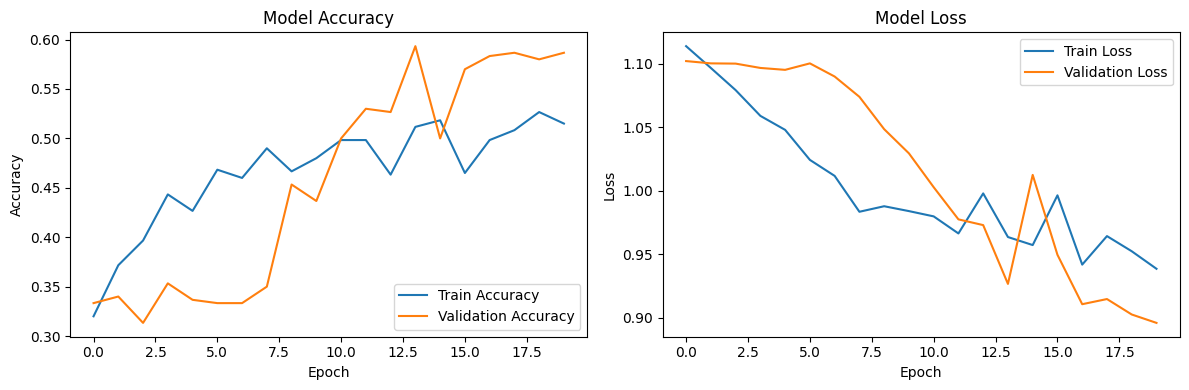

In [19]:
def plot_metrics(history):
    """
    Plots training and validation accuracy and loss.
    
    Args:
        history (History): Training history.
    """
    print("\nPlotting training and validation metrics...")
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_metrics(history)


In [20]:
def save_final_model(model, final_model_path):
    """
    Saves the trained model to the specified path.
    
    Args:
        model (tensorflow.keras.Model): Trained model.
        final_model_path (str): Path to save the model.
    """
    print(f"\nSaving the final model to {final_model_path}...")
    model.save(final_model_path)
    print("Final model saved.")

save_final_model(best_model, os.path.join(LOG_DIR, 'final_model.h5'))


2024-12-02  15:43:13 WARNING You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 



Saving the final model to logs\final_model.h5...
Final model saved.



Analyzing hyperparameter optimization results...
Results summary
Results in kt_dir\image_classification
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 12 summary
Hyperparameters:
freeze_layers: 150
num_dense_layers: 3
units_0: 192
dropout_0: 0.30000000000000004
optimizer: sgd
learning_rate: 0.003078438095192701
units_1: 256
dropout_1: 0.30000000000000004
units_2: 448
dropout_2: 0.1
momentum: 0.7000000000000001
Score: 0.5799999833106995

Trial 13 summary
Hyperparameters:
freeze_layers: 160
num_dense_layers: 2
units_0: 512
dropout_0: 0.30000000000000004
optimizer: sgd
learning_rate: 0.009287959309973642
units_1: 320
dropout_1: 0.0
units_2: 320
dropout_2: 0.2
momentum: 0.2
Score: 0.5600000023841858

Trial 05 summary
Hyperparameters:
freeze_layers: 140
num_dense_layers: 2
units_0: 512
dropout_0: 0.0
optimizer: sgd
learning_rate: 0.0007457155735363331
units_1: 256
dropout_1: 0.0
units_2: 448
dropout_2: 0.0
momentum: 0.5
Score: 0.5199999809265137

Trial 07 sum

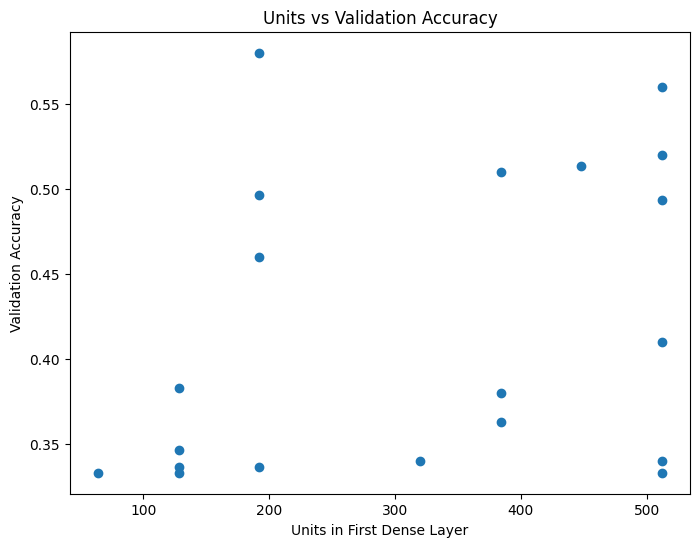

In [24]:
def analyze_hyperparameter_results(tuner, results_file):
    """
    Analyzes and saves hyperparameter optimization results.
    
    Args:
        tuner (kt.tuners.RandomSearch): Hyperparameter tuner.
        results_file (str): Path to save the hyperparameter results.
    """
    print("\nAnalyzing hyperparameter optimization results...")
    tuner.results_summary()
    
    # Save all hyperparameter results to CSV
    print(f"\nSaving hyperparameter results to {results_file}...")
    results = []
    try:
        # Attempt to sort trials using supported parameters
        best_trials = tuner.oracle.get_best_trials(num_trials=50)
        # Manually sort trials based on score
        best_trials = sorted(best_trials, key=lambda t: t.score, reverse=True)
    except TypeError:
        # If sorting parameters are not supported, retrieve without sorting
        print("Unable to sort trials. Retrieving top trials without sorting.")
        best_trials = tuner.oracle.get_best_trials(num_trials=50)
    
    for trial in best_trials:
        params = trial.hyperparameters.values
        score = trial.score
        params['val_accuracy'] = score
        results.append(params)
    
    results_df = pd.DataFrame(results)
    results_df.to_csv(results_file, index=False)
    print(f"Hyperparameter results saved to {results_file}.")
    
    # Example Plot: Units in First Dense Layer vs Validation Accuracy
    if 'units_0' in results_df.columns:
        print("\nPlotting Units in First Dense Layer vs Validation Accuracy...")
        plt.figure(figsize=(8,6))
        plt.scatter(results_df['units_0'], results_df['val_accuracy'])
        plt.xlabel('Units in First Dense Layer')
        plt.ylabel('Validation Accuracy')
        plt.title('Units vs Validation Accuracy')
        plt.show()
    else:
        print("The key 'units_0' does not exist in the results. Skipping plot.")

analyze_hyperparameter_results(tuner, HYPERPARAMETER_RESULTS_FILE)



Generating predictions on test data...
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step

Classification Report:
              precision    recall  f1-score   support

        Bird       0.64      0.69      0.66       100
         Cat       0.51      0.35      0.41       100
         Dog       0.50      0.62      0.56       100

    accuracy                           0.55       300
   macro avg       0.55      0.55      0.54       300
weighted avg       0.55      0.55      0.54       300


Confusion Matrix:


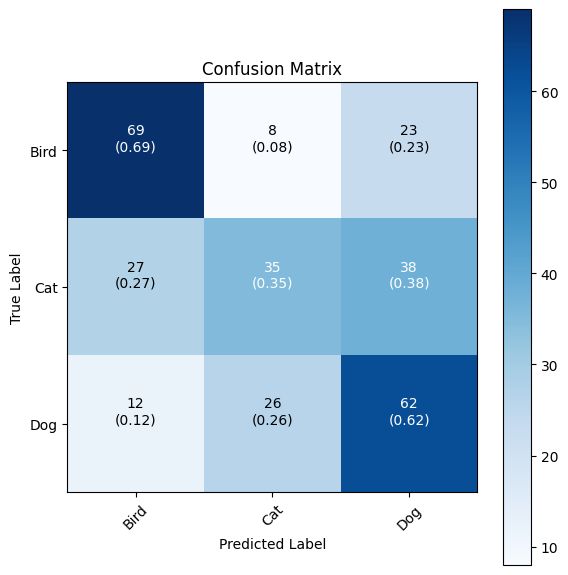

In [25]:
def additional_evaluation(model, test_gen):
    """
    Generates classification report and confusion matrix.
    
    Args:
        model (tensorflow.keras.Model): Trained model.
        test_gen (DirectoryIterator): Test data generator.
    """
    print("\nGenerating predictions on test data...")
    test_predictions = model.predict(test_gen)
    test_pred_classes = np.argmax(test_predictions, axis=1)
    
    # True labels
    test_true_classes = test_gen.classes
    
    # Class labels
    class_labels = list(test_gen.class_indices.keys())
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(test_true_classes, test_pred_classes, target_names=class_labels))
    
    # Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(test_true_classes, test_pred_classes)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    
    # Normalize the confusion matrix.
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Threshold for text color
    thresh = cm.max() / 2.
    
    # Add text annotations.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i, j]}\n({cm_normalized[i, j]:.2f})",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Uncomment the following line to perform additional evaluation
additional_evaluation(best_model, test_generator)


# Model Evaluation Report

## **Confusion Matrix Analysis**

### **Bird (True):**
- **Correct predictions:** 69
- **Misclassified as "Cat":** 8
- **Misclassified as "Dog":** 23

### **Cat (True):**
- **Correct predictions:** 35
- **Misclassified as "Bird":** 27
- **Misclassified as "Dog":** 38

### **Dog (True):**
- **Correct predictions:** 62
- **Misclassified as "Bird":** 12
- **Misclassified as "Cat":** 26

---

## **Interpretation**
1. The model has a strong bias towards **"Bird"** and **"Dog"**, frequently misclassifying **"Cat"** as one of these two.
2. Misclassifications between **"Cat"** and **"Dog"** are particularly high, indicating poor feature differentiation for these classes.
3. The model achieves **55% accuracy** for a 3-class classification problem.
   - Random guessing for 3 classes would give an accuracy of ~33%, so the model is only marginally better than random.

---

## **Recommendations for Improvement**

### **1. Data Augmentation**
- Apply more aggressive data augmentation techniques for underperforming classes (e.g., **"Cat"**) to improve the model's robustness.

### **2. Class Balancing**
- Ensure balanced training samples for all classes.
- Alternatively, introduce **class weights** during training to mitigate the impact of class imbalance.

### **3. Feature Engineering**
- Visualize and analyze the feature representations learned by the model to understand why **"Cat"** is frequently misclassified.
- Consider adding or enhancing **class-specific features** to improve differentiation between classes.

### **4. Fine-Tuning**
- Unfreeze more layers of the pre-trained model (e.g., the top convolutional layers) to allow better feature learning for the challenging classes.

---

By implementing these improvements, the model's performance is likely to improve significantly, particularly in distinguishing between **"Cat"** and other classes.



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/istex9/kishf4/blob/main/hf4.ipynb)
